<a href="https://colab.research.google.com/github/Blueprint-GitHub/Study_Note/blob/main/Deep_learning_with_keras/Deep_learning_with_keras_chapter_9_Advance_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

In [ ]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"

input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".jpg")])
target_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
import random

img_size = (200, 200)
num_imgs = len(input_img_paths)

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
  return img_to_array(load_img(path, target_size = img_size))
def path_to_target(path):
  img = img_to_array(
      load_img(path, target_size = img_size, color_mode = 'grayscale'))
  img = img.astype("uint8") - 1 # 레이블이 0,1,2가 되도록 1을 뺀다
  return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype = 'float32')
targets = np.zeros((num_imgs,) + img_size + (1,), dtype = 'float32')
for i in range(num_imgs):
  input_imgs[i] = path_to_input_image(input_img_paths[i])
  targets[i] = path_to_target(target_paths[i])

#num_val_samples = 1000
train_input_imgs = input_imgs[:-1000]
train_targets = targets[:-1000]
val_input_imgs = input_imgs[-1000:]
val_targets = targets[-1000:]

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(img_size, num_classes):
  inputs = keras.Input(shape = img_size + (3,))

  # kernel_initializer = 'he_normal'로 하는게 더 나음
  x = layers.Rescaling(1./255)(inputs)
  x = layers.Conv2D(64, 3, strides = 2, activation = 'relu', padding = 'same')(x)
  x = layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(x)
  x = layers.Conv2D(128, 3, strides = 2, activation = 'relu', padding = 'same')(x)
  x = layers.Conv2D(128, 3, activation = 'relu', padding = 'same')(x)
  x = layers.Conv2D(256, 3, strides = 2, activation = 'relu', padding = 'same')(x)
  x = layers.Conv2D(256, 3, activation = 'relu', padding = 'same')(x)

  x = layers.Conv2DTranspose(256, 3, activation = 'relu', padding = 'same')(x)
  x = layers.Conv2DTranspose(
      256, 3, activation = 'relu', padding = 'same', strides = 2)(x)
  x = layers.Conv2DTranspose(128, 3, activation = 'relu', padding = 'same')(x)
  x = layers.Conv2DTranspose(
      128, 3, activation = 'relu', padding = 'same', strides = 2)(x)
  x = layers.Conv2DTranspose(64, 3, activation = 'relu', padding = 'same')(x)
  x = layers.Conv2DTranspose(
      64, 3, activation = 'relu', padding = 'same', strides = 2)(x)
  outputs = layers.Conv2D(num_classes, 3, activation = "softmax",
                          padding = "same")(x)
  model = keras.Model(inputs, outputs)
  return model

model = get_model(img_size = img_size, num_classes = 3)
model.compile(optimizer = 'rmsprop',
              loss = 'sparse_categorical_crossentropy')
callbacks = [
    keras.callbacks.ModelCheckpoint('oxford_segmentation.h5',
                                    save_best_only = True)
]
history = model.fit(train_input_imgs, train_targets,
                    epochs = 50,
                    callbacks = callbacks,
                    batch_size = 64,
                    validation_data = (val_input_imgs, val_targets))


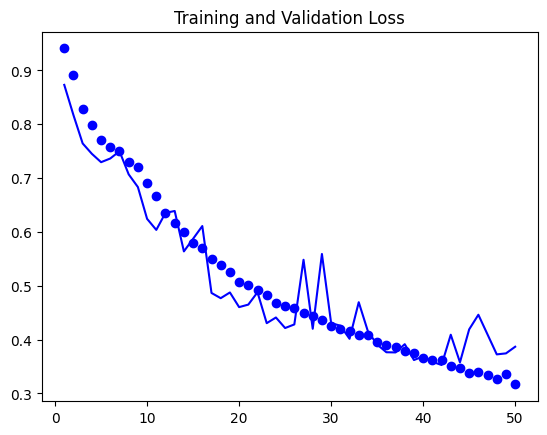

In [ ]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure()
plt.plot(epochs, loss, "bo", label = "Training loss")
plt.plot(epochs, val_loss, "b", label = "Validation loss")
plt.title("Training and Validation Loss")
plt.show()

In [ ]:
# 82.48
# 잔차연결, 정보손실 없이 층을 깊게하기 위한 기술
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape = (32,32,3))
x = layers.Rescaling(1./255)(inputs)

def residual_block(x, filters, pooling = False):
  residual = x
  x = layers.Conv2D(filters, 3, activation = 'relu', padding = 'same')(x)
  x = layers.Conv2D(filters, 3, activation = 'relu', padding = 'same')(x)

  if pooling: # 최대 풀링을 사용하면 원하는 크기를 투영하기 위해 스트라이드 추가
    x = layers.MaxPooling2D(2, padding = 'same')(x)
    residual = layers.Conv2D(filters, 1, strides = 2)(residual)
  elif filters != residual.shape[-1]:
    residual = layers.Conv2D(filters, 1)(residual) #max풀링을 안쓰면 채널수가 바뀔때만 잔차 투영
  x = layers.add([x, residual])
  return x

x = residual_block(x, filters = 32, pooling = True)
x = residual_block(x, filters = 64, pooling = True)
x = residual_block(x, filters = 128, pooling = False) #다음에 전역풀링을 시행하니까 False
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model = keras.Model(inputs, outputs)
model.summary()

```
# 다음과 같이 잔차연결을 Layer를 상속하는 Class로 사용할 수 있으며
이렇게 구현하면 재사용과 확장성 면에서는 유리하다.
Sequential 모델 기준으로
model.add(ResidualUnit(filter,strides)) 이렇게 쓰면 됨.

동작 방식의 차이
- residual_block 함수는 풀링의 유무에 따라 잔차 경로의 연산을 달리하며,
  채널 수의 변경이 필요할 때만 1x1 컨볼루션을 적용.
- ResidualUnit 클래스는 스트라이드 값에 따라 잔차 경로의 연산을 달리하며,
  모든 경로에 배치 정규화를 적용.
  
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="same", kernel_initializer="he_normal",
                        use_bias=False)

class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            tf.keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                tf.keras.layers.BatchNormalization()
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)
```

In [ ]:
# 고급 컨브넷 기술
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs) #데이터 증식

x = layers.Rescaling(1./255)(x)  # 스케일 조정
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)
# 시작단계에서는 깊이별분리합성곱이 RGB처럼 층별로 상관관계가 깊은 단계에서
# 사용하기 어려우므로 일반 conv2D를 사용.
# 깊이별분리합성곱은 채널(깊이)가 다르면 상관관계가 없다고 가정함.
for size in [32, 64, 128, 256, 512]:
    residual = x

    x = layers.BatchNormalization()(x)  # 배치 정규화
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x) #깊이별분리합성곱

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x) # 전역 평균 풀링
x = layers.Dropout(0.5)(x) #드롭 아웃
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset)

In [ ]:
# 합성곱 모델 시각화 과정 출력
from tensorflow import keras
model = keras.models.load_model(
    'convnet_from_scratch_chapter_8.h5')
model.summary()

In [ ]:
# 1개 이미지 전처리
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

img_path = keras.utils.get_file(
    fname = 'cat.jpg',
    origin = 'https://img-datasets.s3.amazonaws.com/cat.jpg')

def get_img_array(img_path, target_size):
  img = keras.utils.load_img(
      img_path, target_size = target_size)
  array = keras.utils.img_to_array(img) #(180,180,3)의 넘파이 배열로 변환
  array = np.expand_dims(array, axis = 0) #차원 추가(1,180,180,3)
  return array

img_tensor = get_img_array(img_path, target_size = (180,180))

In [ ]:
from tensorflow.keras import layers

layer_outputs = []
layer_names = []
for layer in model.layers: #Conv2D층과 MaxPooling2D층의 출력을 리스트에 추가
  if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
    layer_outputs.append(layer.output)
    layer_names.append(layer.name)

activation_model = keras.Model(inputs= model.input, outputs = layer_outputs)

In [ ]:
activations = activation_model.predict(img_tensor)

In [ ]:
# 1개의 이미지에 대해 컨볼루션 층이 깊어지는 그림을 보면
# 층이 깊어지면서 점점 더 픽셀화 된다(추상적)
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros(((size + 1) * n_cols - 1,
                             images_per_row * (size + 1) - 1))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            channel_image = layer_activation[0, :, :, channel_index].copy()
            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype("uint8")
            display_grid[
                col * (size + 1): (col + 1) * size + col,
                row * (size + 1) : (row + 1) * size + row] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, aspect="auto", cmap="viridis")

In [ ]:
#1 Xception을 활용한 컨브넷 필터 시각화 하기

model = keras.applications.xception.Xception(
    weights = 'imagenet',
    include_top = False)

In [ ]:
#2 블록 14개, 층 40개
for layer in model.layers:
  if isinstance(layer, (keras.layers.Conv2D, keras.layers.SeparableConv2D)):
    print(layer.name)

In [ ]:
#3 특성 추출 모델 만들기
layer_name = "block13_sepconv2" # 이 이름만 바꾸고 밑에 코드 한번씩 실행시키면
# 컨브넷 모델이 뭘 보고 있는지 알 수 있음
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.input, outputs=layer.output)

In [ ]:
#4 특성 추출 모델 사용하기
# xception 모델의 입력은 아래처럼 전처리 되어야 함.
activation = feature_extractor(
    keras.applications.xception.preprocess_input(img_tensor)
)

In [ ]:
import tensorflow as tf

#5 이미지가 필터를 활성화하는 정도를 스칼라로 나타낼 수 있음.
def compute_loss(image, filter_index):
    activation = feature_extractor(image)
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

In [ ]:
@tf.function
#6 그레이디언트를 증가시키는 방향(경사상승법, 특정 필터의 응답을 최대로 하기 위해서 ㅇㅇ)
def gradient_ascent_step(image, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image, filter_index)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return image

In [ ]:
#7 필터 시각화 생성

img_width = 200
img_height = 200

def generate_filter_pattern(filter_index):
    iterations = 30
    learning_rate = 10.
    image = tf.random.uniform(
        minval=0.4,
        maxval=0.6,
        shape=(1, img_width, img_height, 3))
    for i in range(iterations):
        image = gradient_ascent_step(image, filter_index, learning_rate)
    return image[0].numpy()

In [ ]:
#8 텐서를 이미지로 변환

def deprocess_image(image):
    image -= image.mean()
    image /= image.std()
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype("uint8")
    image = image[25:-25, 25:-25, :]
    return image

In [ ]:
# 9 출력

plt.axis("off")
plt.imshow(deprocess_image(generate_filter_pattern(filter_index=2)))
plt.show()

In [ ]:
all_images = []
for filter_index in range(64):
    print(f"{filter_index}번 필터 처리중")
    image = deprocess_image(
        generate_filter_pattern(filter_index)
    )
    all_images.append(image)

margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

for i in range(n):
    for j in range(n):
        image = all_images[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = image

keras.utils.save_img(
    f"filters_for_layer_{layer_name}.png", stitched_filters)

0번 필터 처리중
1번 필터 처리중
2번 필터 처리중
3번 필터 처리중
4번 필터 처리중
5번 필터 처리중
6번 필터 처리중
7번 필터 처리중
8번 필터 처리중
9번 필터 처리중
10번 필터 처리중
11번 필터 처리중
12번 필터 처리중
13번 필터 처리중
14번 필터 처리중
15번 필터 처리중
16번 필터 처리중
17번 필터 처리중
18번 필터 처리중
19번 필터 처리중
20번 필터 처리중
21번 필터 처리중
22번 필터 처리중
23번 필터 처리중
24번 필터 처리중
25번 필터 처리중
26번 필터 처리중
27번 필터 처리중
28번 필터 처리중
29번 필터 처리중
30번 필터 처리중
31번 필터 처리중
32번 필터 처리중
33번 필터 처리중
34번 필터 처리중
35번 필터 처리중
36번 필터 처리중
37번 필터 처리중
38번 필터 처리중
39번 필터 처리중
40번 필터 처리중
41번 필터 처리중
42번 필터 처리중
43번 필터 처리중
44번 필터 처리중
45번 필터 처리중
46번 필터 처리중
47번 필터 처리중
48번 필터 처리중
49번 필터 처리중
50번 필터 처리중
51번 필터 처리중
52번 필터 처리중
53번 필터 처리중
54번 필터 처리중
55번 필터 처리중
56번 필터 처리중
57번 필터 처리중
58번 필터 처리중
59번 필터 처리중
60번 필터 처리중
61번 필터 처리중
62번 필터 처리중
63번 필터 처리중
